# Лабораторная работа №5. Модель латентных факторов (LFM)

В рамках данной лабораторной работы предстоит реализовать модель латентных факторов (LFM) и сравнить её с эталонной реализацией из библиотеки `scikit-learn`.

## Задание

1. Выбрать датасет для анализа, например, на [kaggle](https://www.kaggle.com/datasets).
2. Реализовать модель латентных факторов.
3. Обучить модель на выбранном датасете.
4. Оценить качество модели с использованием метрик, таких как RMSE или MAE.
5. Замерить время обучения модели.
6. Сравнить результаты с эталонной реализацией из библиотеки [scikit-learn](https://scikit-learn.org/stable/):
   * точность модели;
   * время обучения.
7. Подготовить отчет, включающий:
   * описание модели латентных факторов;
   * описание датасета;
   * результаты экспериментов;
   * сравнение с эталонной реализацией;
   * выводы.

# 1. Выбрать датасет для анализа, например, на [kaggle](https://www.kaggle.com/datasets).

### В качестве датасета был выбран набор данных Movie Lens для рекомендательных систем

### Ссылка:

https://www.kaggle.com/datasets/aigamer/movie-lens-dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aigamer/movie-lens-dataset")

print("Path to dataset files:", path)

c:\Users\klimm\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\klimm\.cache\kagglehub\datasets\aigamer\movie-lens-dataset\versions\1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
print("movies")
movies.info()
print("ratings")
ratings.info()

movies
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
ratings
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


## Анализ рейтингов

In [7]:
unique_users_count = ratings['userId'].nunique()
unique_movies_count = ratings['movieId'].nunique()

print(f"Уникальных пользователей: {unique_users_count}")
print(f"Уникальных фильмов: {unique_movies_count}")
print(f"Количество рейтингов: {len(ratings)}")

Уникальных пользователей: 610
Уникальных фильмов: 9724
Количество рейтингов: 100836


In [8]:
total_possible_ratings = unique_users_count * unique_movies_count
sparsity = 1 - (len(ratings) / total_possible_ratings)

print(f"Разряженность матрицы: {sparsity:.4f} ({sparsity*100:.2f}%)")

Разряженность матрицы: 0.9830 (98.30%)


Матрица имеет высокую разрежнность

Выведим статистические данные и посмотрим на распределение

In [9]:
mean_rating = ratings['rating'].mean()
std_rating = ratings['rating'].std()

print(f"Средний рейтинг: {mean_rating:.2f}")
print(f"Стандартное отклонение: {std_rating:.2f}")
print(f"Диапазон рейтингов: {ratings['rating'].min()} - {ratings['rating'].max()}")

Средний рейтинг: 3.50
Стандартное отклонение: 1.04
Диапазон рейтингов: 0.5 - 5.0


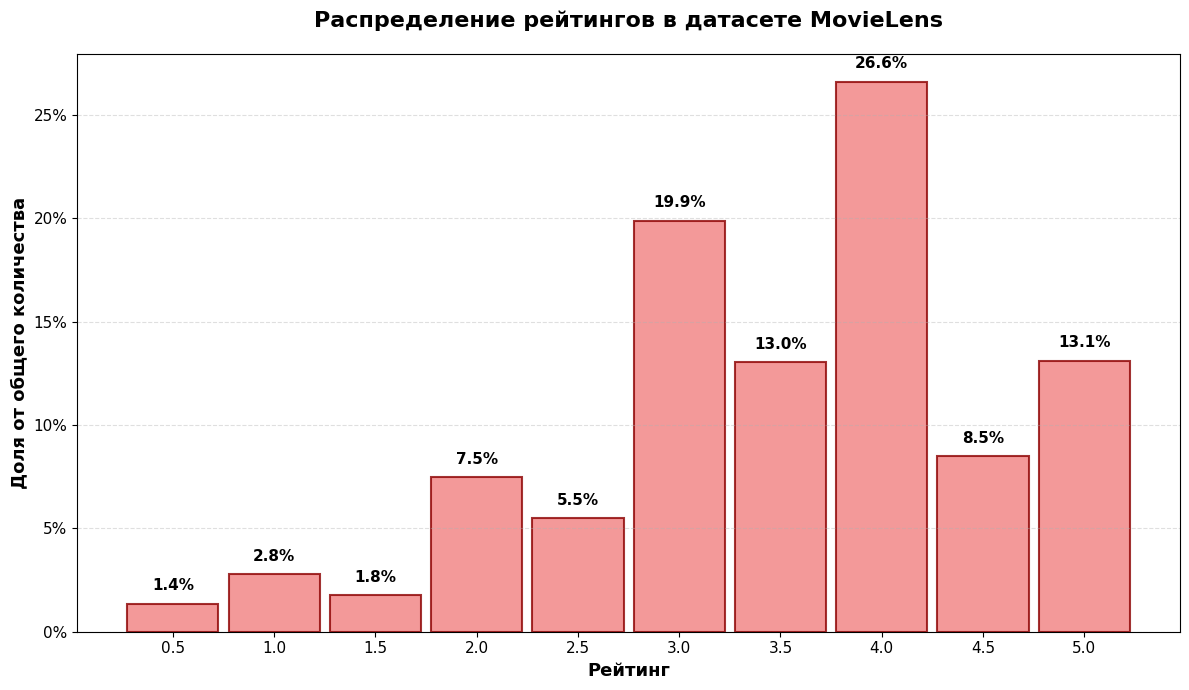

In [10]:
# Визуализация распределения рейтингов
rating_dist = ratings['rating'].value_counts(normalize=True).sort_index()

plt.figure(figsize=(12, 7))

# Создаем столбцы
bars = plt.bar(rating_dist.index, rating_dist.values, 
               width=0.45,
               color='lightcoral', 
               edgecolor='darkred', 
               linewidth=1.5, 
               alpha=0.8)

# Добавляем проценты на столбцы
for bar, pct in zip(bars, rating_dist.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{pct:.1%}', ha='center', va='bottom', 
             fontweight='bold', fontsize=11)

# Настройка осей и внешнего вида
plt.title('Распределение рейтингов в датасете MovieLens', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Рейтинг', fontsize=13, fontweight='bold')
plt.ylabel('Доля от общего количества', fontsize=13, fontweight='bold')

# Сетка
plt.grid(axis='y', alpha=0.4, linestyle='--')

# Настраиваем деления на оси X
plt.xticks(rating_dist.index, fontsize=11)
plt.yticks(fontsize=11)

# Форматируем ось Y в процентах
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.tight_layout()
plt.show()

## Выводы
- Пользователи склонны чаще оценивать фильмы, которые им нравятся
- Умеренный разброс: (std = 1.04)
- Baseline для RMSE: 1.04
- Самый популярный рейтинг: 4.0 (26.6%)
- Рейтинги 0.5-1.5 скорее всего будут плохо предсказываться из-за смещения распределения вправо
- Понадобится задать смещение по среднему: 3.5
- Вероятно понадобится высокое значение регуляризации, чтобы предотвратить переобучение на разряженных данных

# 2. Реализовать модель латентных факторов.

Разделяем данные и создаем индексы через маппинг в обе стороны: для обучения и для интерпретации результатов

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time

In [12]:
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

In [13]:
unique_users_list = ratings['userId'].unique()
unique_movies_list = ratings['movieId'].unique()

In [14]:
user_to_idx = {user: idx for idx, user in enumerate(unique_users_list)}
movie_to_idx = {movie: idx for idx, movie in enumerate(unique_movies_list)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}
idx_to_movies = {idx: movie for movie, idx in movie_to_idx.items()}

In [15]:
class CustomLatentFactorModel:
    def __init__(self, n_factors=50, learning_rate=0.01, regularization=0.1, n_epochs=100, random_state=42):
        """
        Модель латентных факторов с bias

        Параметры:
        n_factors: количество скрытых факторов
        learning_rate: скорость обучения
        regularization: параметр регуляризации
        n_epochs: количество эпох обучения
        """
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.n_epochs = n_epochs
        self.random_state = random_state

        # Параметры модели для инициализации в fit
        self.global_bias = None
        self.user_bias = None
        self.movie_bias = None
        self.user_factors = None
        self.movie_factors = None
        self.n_users = None
        self.n_movies = None

        # История обучения
        self.train_rmse_history = []

    def fit(self, train_data, user_to_idx, movie_to_idx, verbose=True):
        """Обучение модели"""
        np.random.seed(self.random_state)

        # Размеры данных
        self.n_users = len(user_to_idx)
        self.n_movies = len(movie_to_idx)

        # Глобальное смещение = среднему рейтингу
        self.global_bias = train_data['rating'].mean()

        # Инициализация bias
        self.user_bias = np.zeros(self.n_users)
        self.movie_bias = np.zeros(self.n_movies)

        # Инициализация факторов
        init_std = 0.1
        self.user_factors = np.random.normal(0, init_std, (self.n_users, self.n_factors))
        self.movie_factors = np.random.normal(0, init_std, (self.n_movies, self.n_factors))

        # Подготовка данных для SGD
        user_indices = [user_to_idx[user] for user in train_data['userId']]
        movie_indices = [movie_to_idx[movie] for movie in train_data['movieId']]
        ratings_array = train_data['rating'].values

        if verbose:
            print(f"Начало обучения LFM:")
            print(f"Факторов: {self.n_factors}")
            print(f"Learning rate: {self.learning_rate}")
            print(f"Регуляризация: {self.regularization}")
            print(f"Глобальное смещение: {self.global_bias:.2f}")
        
        # SGD обучение
        for epoch in range(self.n_epochs):
            epoch_error = 0
            n_ratings = len(user_indices)

            # Создаем перемешанную последвательность индексов
            indices = np.random.permutation(n_ratings)
            
            for idx in indices:
                user_idx = user_indices[idx]
                movie_idx = movie_indices[idx]
                rating = ratings_array[idx]

                # Предсказание
                prediction = self._predict_single(user_idx, movie_idx)
                error = rating - prediction
                epoch_error += error ** 2

                # Сохраняем текущие значения для обновления
                user_factors_old = self.user_factors[user_idx, :].copy()
                movie_factors_old = self.movie_factors[movie_idx, :].copy()

                # Обновляем bias
                self.user_bias[user_idx] += self.learning_rate * (
                    error - self.regularization * self.user_bias[user_idx]
                )
                self.movie_bias[movie_idx] += self.learning_rate * (
                    error - self.regularization * self.movie_bias[movie_idx]
                )

                # Обновление факторов
                self.user_factors[user_idx, :] += self.learning_rate * (
                    error * movie_factors_old - self.regularization * user_factors_old
                )
                self.movie_factors[movie_idx, :] += self.learning_rate * (
                    error * user_factors_old - self.regularization * movie_factors_old
                )

            # Вычисляем RMSE для эпохи
            epoch_rmse = np.sqrt(epoch_error / n_ratings)
            self.train_rmse_history.append(epoch_rmse)

            # Отображаем прогресс
            if verbose:
                print(f"Эпоха {epoch + 1}: RMSE = {epoch_rmse:.4f}")
        
        if verbose:
            print(f"Обучение завершено. Финальный RMSE: {self.train_rmse_history[-1]:.4f}")

    def _predict_single(self, user_idx, movie_idx):
        """Предсказание для одной пары пользователь-фильм"""
        prediction = (
            self.global_bias +
            self.user_bias[user_idx] +
            self.movie_bias[movie_idx] +
            np.dot(self.user_factors[user_idx, :], self.movie_factors[movie_idx, :])
        )
        return prediction
    
    def predict(self, user_id, movie_id, user_to_idx, movie_to_idx):
        """Предсказание рейтинга для пользователя и фильма"""
        if user_id not in user_to_idx or movie_id not in movie_to_idx:
            return self.global_bias # Возвращаем средний рейтинг для неизвестных
        
        user_idx = user_to_idx[user_id]
        movie_idx = movie_to_idx[movie_id]

        return self._predict_single(user_idx, movie_idx)

    def predict_batch(self, test_data, user_to_idx, movie_to_idx):
        """Предсказания для датасета"""
        predictions = []

        for user_id, movie_id in zip(test_data['userId'], test_data['movieId']):
            pred = self.predict(user_id, movie_id, user_to_idx, movie_to_idx)
            predictions.append(pred)
    
        return np.array(predictions)

In [16]:
def evaluate_model(model, test_data, user_to_idx, movie_to_idx):
    """Оценка качества модели"""
    predictions = model.predict_batch(test_data, user_to_idx, movie_to_idx)
    actual = test_data['rating'].values
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    
    return rmse, predictions

# 3-5. Обучить модель на выбранном датасете, оценить качество модели с использованием метрик, таких как RMSE или MAE и замерить время обучения модели.

In [17]:
# Создаем модель с параметрами, основанными на анализе
model_1 = CustomLatentFactorModel(
    n_factors=50,
    learning_rate=0.01,
    regularization=0.1,
    n_epochs=100,
    random_state=42
)

# Замеряем время обучения
start_time = time.time()
model_1.fit(train_data, user_to_idx, movie_to_idx, verbose=True)
training_time = time.time() - start_time

print(f"\nВремя обучения: {training_time:.2f} секунд")

Начало обучения LFM:
Факторов: 50
Learning rate: 0.01
Регуляризация: 0.1
Глобальное смещение: 3.50
Эпоха 1: RMSE = 0.9447
Эпоха 2: RMSE = 0.8882
Эпоха 3: RMSE = 0.8674
Эпоха 4: RMSE = 0.8544
Эпоха 5: RMSE = 0.8446
Эпоха 6: RMSE = 0.8367
Эпоха 7: RMSE = 0.8300
Эпоха 8: RMSE = 0.8240
Эпоха 9: RMSE = 0.8187
Эпоха 10: RMSE = 0.8133
Эпоха 11: RMSE = 0.8084
Эпоха 12: RMSE = 0.8036
Эпоха 13: RMSE = 0.7988
Эпоха 14: RMSE = 0.7938
Эпоха 15: RMSE = 0.7887
Эпоха 16: RMSE = 0.7834
Эпоха 17: RMSE = 0.7781
Эпоха 18: RMSE = 0.7725
Эпоха 19: RMSE = 0.7669
Эпоха 20: RMSE = 0.7611
Эпоха 21: RMSE = 0.7549
Эпоха 22: RMSE = 0.7489
Эпоха 23: RMSE = 0.7426
Эпоха 24: RMSE = 0.7364
Эпоха 25: RMSE = 0.7300
Эпоха 26: RMSE = 0.7236
Эпоха 27: RMSE = 0.7173
Эпоха 28: RMSE = 0.7113
Эпоха 29: RMSE = 0.7048
Эпоха 30: RMSE = 0.6988
Эпоха 31: RMSE = 0.6927
Эпоха 32: RMSE = 0.6870
Эпоха 33: RMSE = 0.6812
Эпоха 34: RMSE = 0.6754
Эпоха 35: RMSE = 0.6701
Эпоха 36: RMSE = 0.6646
Эпоха 37: RMSE = 0.6596
Эпоха 38: RMSE = 0.654

In [18]:
# Оценка на тестовом множестве
rmse, predictions = evaluate_model(model_1, test_data, user_to_idx, movie_to_idx)

print(f"RMSE: {rmse:.4f}")
print(f"Baseline RMSE: 1.04")

if rmse < 1.04:
    print("Модель работает лучше baseline")
else:
    print("Модель хуже baseline, нужна настройка параметров")

# Анализ предсказаний
print(f"\nАнализ предсказаний:")
print(f"Средний предсказанный рейтинг: {predictions.mean():.2f}")
print(f"Средний реальный рейтинг: {test_data['rating'].mean():.2f}")
print(f"Мин. предсказание: {predictions.min():.2f}")
print(f"Макс. предсказание: {predictions.max():.2f}")

RMSE: 0.8584
Baseline RMSE: 1.04
Модель работает лучше baseline

Анализ предсказаний:
Средний предсказанный рейтинг: 3.51
Средний реальный рейтинг: 3.50
Мин. предсказание: 0.93
Макс. предсказание: 5.24


Попробуем уменьшить регуляризацию в 10 раз

In [19]:
# Создаем модель с параметрами, основанными на анализе данных
model_2 = CustomLatentFactorModel(
    n_factors=50,
    learning_rate=0.01,
    regularization=0.01,
    n_epochs=100,
    random_state=42
)

# Замеряем время обучения
start_time = time.time()
model_2.fit(train_data, user_to_idx, movie_to_idx, verbose=True)
training_time = time.time() - start_time

print(f"\nВремя обучения: {training_time:.2f} секунд")

Начало обучения LFM:
Факторов: 50
Learning rate: 0.01
Регуляризация: 0.01
Глобальное смещение: 3.50
Эпоха 1: RMSE = 0.9442
Эпоха 2: RMSE = 0.8848
Эпоха 3: RMSE = 0.8598
Эпоха 4: RMSE = 0.8409
Эпоха 5: RMSE = 0.8238
Эпоха 6: RMSE = 0.8064
Эпоха 7: RMSE = 0.7877
Эпоха 8: RMSE = 0.7666
Эпоха 9: RMSE = 0.7431
Эпоха 10: RMSE = 0.7172
Эпоха 11: RMSE = 0.6894
Эпоха 12: RMSE = 0.6608
Эпоха 13: RMSE = 0.6320
Эпоха 14: RMSE = 0.6038
Эпоха 15: RMSE = 0.5768
Эпоха 16: RMSE = 0.5513
Эпоха 17: RMSE = 0.5271
Эпоха 18: RMSE = 0.5046
Эпоха 19: RMSE = 0.4837
Эпоха 20: RMSE = 0.4642
Эпоха 21: RMSE = 0.4462
Эпоха 22: RMSE = 0.4295
Эпоха 23: RMSE = 0.4138
Эпоха 24: RMSE = 0.3994
Эпоха 25: RMSE = 0.3859
Эпоха 26: RMSE = 0.3733
Эпоха 27: RMSE = 0.3616
Эпоха 28: RMSE = 0.3507
Эпоха 29: RMSE = 0.3405
Эпоха 30: RMSE = 0.3309
Эпоха 31: RMSE = 0.3219
Эпоха 32: RMSE = 0.3135
Эпоха 33: RMSE = 0.3057
Эпоха 34: RMSE = 0.2981
Эпоха 35: RMSE = 0.2911
Эпоха 36: RMSE = 0.2845
Эпоха 37: RMSE = 0.2783
Эпоха 38: RMSE = 0.27

In [20]:
# Оценка на тестовом множестве
rmse, predictions = evaluate_model(model_2, test_data, user_to_idx, movie_to_idx)

print(f"RMSE: {rmse:.4f}")
print(f"Baseline RMSE: 1.04")

if rmse < 1.04:
    print("Модель работает лучше baseline")
else:
    print("Модель хуже baseline, нужна настройка параметров")

# Анализ предсказаний
print(f"\nАнализ предсказаний:")
print(f"Средний предсказанный рейтинг: {predictions.mean():.2f}")
print(f"Средний реальный рейтинг: {test_data['rating'].mean():.2f}")
print(f"Мин. предсказание: {predictions.min():.2f}")
print(f"Макс. предсказание: {predictions.max():.2f}")

RMSE: 0.9604
Baseline RMSE: 1.04
Модель работает лучше baseline

Анализ предсказаний:
Средний предсказанный рейтинг: 3.51
Средний реальный рейтинг: 3.50
Мин. предсказание: -0.03
Макс. предсказание: 7.15


Получили переобучение, попробуем увеличить в пять (или уменьшить вдвое по сравнению с изначальным значением регуляризации)

In [21]:
# Создаем модель с параметрами, основанными на анализе данных
model_3 = CustomLatentFactorModel(
    n_factors=50,
    learning_rate=0.1,
    regularization=0.05,
    n_epochs=100,
    random_state=42
)

# Замеряем время обучения
start_time = time.time()
model_3.fit(train_data, user_to_idx, movie_to_idx, verbose=True)
training_time = time.time() - start_time

print(f"\nВремя обучения: {training_time:.2f} секунд")

Начало обучения LFM:
Факторов: 50
Learning rate: 0.1
Регуляризация: 0.05
Глобальное смещение: 3.50
Эпоха 1: RMSE = 0.9142
Эпоха 2: RMSE = 0.8245
Эпоха 3: RMSE = 0.7220
Эпоха 4: RMSE = 0.6182
Эпоха 5: RMSE = 0.5457
Эпоха 6: RMSE = 0.4963
Эпоха 7: RMSE = 0.4627
Эпоха 8: RMSE = 0.4395
Эпоха 9: RMSE = 0.4229
Эпоха 10: RMSE = 0.4095
Эпоха 11: RMSE = 0.4006
Эпоха 12: RMSE = 0.3937
Эпоха 13: RMSE = 0.3878
Эпоха 14: RMSE = 0.3837
Эпоха 15: RMSE = 0.3802
Эпоха 16: RMSE = 0.3764
Эпоха 17: RMSE = 0.3735
Эпоха 18: RMSE = 0.3712
Эпоха 19: RMSE = 0.3700
Эпоха 20: RMSE = 0.3677
Эпоха 21: RMSE = 0.3667
Эпоха 22: RMSE = 0.3655
Эпоха 23: RMSE = 0.3645
Эпоха 24: RMSE = 0.3642
Эпоха 25: RMSE = 0.3617
Эпоха 26: RMSE = 0.3612
Эпоха 27: RMSE = 0.3606
Эпоха 28: RMSE = 0.3590
Эпоха 29: RMSE = 0.3584
Эпоха 30: RMSE = 0.3591
Эпоха 31: RMSE = 0.3580
Эпоха 32: RMSE = 0.3575
Эпоха 33: RMSE = 0.3573
Эпоха 34: RMSE = 0.3564
Эпоха 35: RMSE = 0.3562
Эпоха 36: RMSE = 0.3554
Эпоха 37: RMSE = 0.3553
Эпоха 38: RMSE = 0.354

In [22]:
# Оценка на тестовом множестве
rmse, predictions = evaluate_model(model_3, test_data, user_to_idx, movie_to_idx)

print(f"RMSE: {rmse:.4f}")
print(f"Baseline RMSE: 1.04")

if rmse < 1.04:
    print("Модель работает лучше baseline")
else:
    print("Модель хуже baseline, нужна настройка параметров")

# Анализ предсказаний
print(f"\nАнализ предсказаний:")
print(f"Средний предсказанный рейтинг: {predictions.mean():.2f}")
print(f"Средний реальный рейтинг: {test_data['rating'].mean():.2f}")
print(f"Мин. предсказание: {predictions.min():.2f}")
print(f"Макс. предсказание: {predictions.max():.2f}")

RMSE: 0.8844
Baseline RMSE: 1.04
Модель работает лучше baseline

Анализ предсказаний:
Средний предсказанный рейтинг: 3.53
Средний реальный рейтинг: 3.50
Мин. предсказание: 0.70
Макс. предсказание: 5.76


Немного хуже, чем с изначальным значением регуляризации (0.1)

Поэкспериментируем с числом фактором

In [23]:
def test_factor_range(train_data, test_data, user_to_idx, movie_to_idx, 
                     factor_range=range(20, 81, 10), fixed_params=None):
    """
    Тестирование разного количества факторов
    Возвращает DataFrame с результатами и лучшую модель
    """
    if fixed_params is None:
        fixed_params = {
            'learning_rate': 0.01,
            'regularization': 0.1,
            'n_epochs': 100,
            'random_state': 42
        }
    
    results = []
    best_model = None
    best_test_rmse = float('inf')
    best_n_factors = None
    
    print("Тестирование количества факторов:")
    print(f"Диапазон: {min(factor_range)} - {max(factor_range)}")
    
    for n_factors in factor_range:
        print(f"\nФакторов: {n_factors}")
        
        # Создаем и обучаем модель
        model = CustomLatentFactorModel(n_factors=n_factors, **fixed_params)
        start_time = time.time()
        model.fit(train_data, user_to_idx, movie_to_idx, verbose=False)
        training_time = time.time() - start_time

        # Оцениваем модель
        test_rmse, _ = evaluate_model(model, test_data, user_to_idx, movie_to_idx)
        train_rmse, _ = evaluate_model(model, train_data, user_to_idx, movie_to_idx)
        
        overfitting_gap = test_rmse - train_rmse
        
        # Сохраняем результат
        result = {
            'n_factors': n_factors,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'overfitting_gap': overfitting_gap,
            'training_time': training_time
        }
        
        results.append(result)
        print(f"Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f} | Gap: {overfitting_gap:.4f} | Время: {training_time:.1f}с")
        
        # Проверяем, является ли модель лучшей
        if test_rmse < best_test_rmse:
            best_test_rmse = test_rmse
            best_model = model
            best_n_factors = n_factors
    
    print(f"Лучшая модель: {best_n_factors} факторов")
    print(f"Лучший Test RMSE: {best_test_rmse:.4f}")
    
    return pd.DataFrame(results), best_model, best_n_factors

In [24]:
# Тестирование значений факторов
results_df, best_model, best_n_factors = test_factor_range(
    train_data, test_data, user_to_idx, movie_to_idx,
    factor_range=range(20, 81, 10)
)

Тестирование количества факторов:
Диапазон: 20 - 80

Факторов: 20
Train RMSE: 0.5573 | Test RMSE: 0.8674 | Gap: 0.3101 | Время: 74.5с

Факторов: 30
Train RMSE: 0.5306 | Test RMSE: 0.8609 | Gap: 0.3303 | Время: 64.7с

Факторов: 40
Train RMSE: 0.5156 | Test RMSE: 0.8594 | Gap: 0.3437 | Время: 65.3с

Факторов: 50
Train RMSE: 0.5080 | Test RMSE: 0.8584 | Gap: 0.3504 | Время: 68.4с

Факторов: 60
Train RMSE: 0.4999 | Test RMSE: 0.8574 | Gap: 0.3575 | Время: 66.1с

Факторов: 70
Train RMSE: 0.4958 | Test RMSE: 0.8578 | Gap: 0.3620 | Время: 74.7с

Факторов: 80
Train RMSE: 0.4928 | Test RMSE: 0.8586 | Gap: 0.3658 | Время: 74.8с
Лучшая модель: 60 факторов
Лучший Test RMSE: 0.8574


# 6. Сравнить результаты с эталонной реализацией из библиотеки [scikit-learn](https://scikit-learn.org/stable/):
   * точность модели;
   * время обучения.

Взял suprise SVD для сравнения

In [25]:
from surprise import SVD, Dataset, Reader

In [26]:
reader = Reader(rating_scale=(0.5, 5.0))
dataset = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)

svd = SVD(
        n_factors=60,
        lr_all=0.01,
        reg_all=0.1,
        n_epochs=100,
        random_state=42,
        verbose=False
    )

start_time = time.time()
trainset = dataset.build_full_trainset()
svd.fit(trainset)
svd_train_time = time.time() - start_time

train_pred = [svd.predict(row['userId'], row['movieId']).est for _, row in train_data.iterrows()]
train_rmse = np.sqrt(mean_squared_error(train_data['rating'], train_pred))

test_pred = [svd.predict(row['userId'], row['movieId']).est for _, row in test_data.iterrows()]
test_rmse = np.sqrt(mean_squared_error(test_data['rating'], test_pred))
    

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Время обучения: {svd_train_time:.2f}с")

Train RMSE: 0.5016
Test RMSE: 0.8586
Время обучения: 3.60с


Функционал для рекоммендаций

In [27]:
def get_movie_recommendations(user_id, model, n_recommendations=10, 
                               user_to_idx=user_to_idx, movie_to_idx=movie_to_idx, 
                               idx_to_movies=idx_to_movies, movies_df=movies, ratings_df=ratings):
    """
    Получить рекомендации фильмов для пользователя
    
    Параметры:
    user_id: ID пользователя
    model: обученная модель LFM
    n_recommendations: количество рекомендаций (по умолчанию 10)
    user_to_idx, movie_to_idx, idx_to_movies: маппинги индексов
    movies_df: DataFrame с информацией о фильмах
    ratings_df: DataFrame с рейтингами
    
    Возвращает:
    DataFrame с рекомендованными фильмами и предсказанными рейтингами
    """
    # Проверяем, есть ли пользователь в датасете
    if user_id not in user_to_idx:
        print(f"Пользователь {user_id} не найден в датасете")
        return None
    
    # Получаем фильмы, которые пользователь уже оценил
    user_rated_movies = set(ratings_df[ratings_df['userId'] == user_id]['movieId'].values)
    
    # Получаем все фильмы из датасета
    all_movies = set(movie_to_idx.keys())
    
    # Фильмы, которые пользователь еще не оценивал
    unrated_movies = all_movies - user_rated_movies
    
    print(f"Пользователь {user_id} оценил {len(user_rated_movies)} фильмов")
    print(f"Доступно для рекомендации: {len(unrated_movies)} фильмов")
    
    # Предсказываем рейтинги для всех неоцененных фильмов
    movie_predictions = []
    
    for movie_id in unrated_movies:
        predicted_rating = model.predict(user_id, movie_id, user_to_idx, movie_to_idx)
        movie_predictions.append({
            'movieId': movie_id,
            'predicted_rating': predicted_rating
        })
    
    # Создаем DataFrame с предсказаниями
    predictions_df = pd.DataFrame(movie_predictions)
    
    # Сортируем по предсказанному рейтингу (по убыванию)
    predictions_df = predictions_df.sort_values('predicted_rating', ascending=False)
    
    # Берем топ-N рекомендаций
    top_recommendations = predictions_df.head(n_recommendations)
    
    # Добавляем информацию о фильмах (название и жанры)
    recommendations_with_info = top_recommendations.merge(
        movies_df[['movieId', 'title', 'genres']], 
        on='movieId', 
        how='left'
    )
    
    # Рекомендации
    recommendations_with_info['predicted_rating'] = recommendations_with_info['predicted_rating']
    
    return recommendations_with_info[['movieId', 'title', 'genres', 'predicted_rating']]

In [28]:
recommendations = get_movie_recommendations(1, best_model, n_recommendations=10)
print(recommendations)

Пользователь 1 оценил 232 фильмов
Доступно для рекомендации: 9492 фильмов
   movieId                                             title  \
0     5328                                       Rain (2001)   
1   177593  Three Billboards Outside Ebbing, Missouri (2017)   
2     5915         Victory (a.k.a. Escape to Victory) (1981)   
3   171495                                            Cosmos   
4     4429                                  Moby Dick (1956)   
5     6460                    Trial, The (Procès, Le) (1962)   
6     7121                                 Adam's Rib (1949)   
7    78836                             Enter the Void (2009)   
8    87234                                  Submarine (2010)   
9     5490                                The Big Bus (1976)   

                 genres  predicted_rating  
0         Drama|Romance          5.249173  
1           Crime|Drama          5.236570  
2      Action|Drama|War          5.215641  
3    (no genres listed)          5.213880  
4

Отчет приложен в README.md